In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statistics import mean
from tqdm.notebook import tqdm
import missingno as mn
import plotly.express as px
from scipy import stats
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,StandardScaler,power_transform,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold,StratifiedKFold,RepeatedKFold, GridSearchCV, RandomizedSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve,f1_score,accuracy_score
from sklearn.svm import LinearSVC,SVC
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier
from mlxtend.classifier import StackingClassifier
import warnings
warnings.simplefilter('ignore')
from xgboost import XGBClassifier
from scipy import stats
from scipy.stats import loguniform, randint
from skopt import BayesSearchCV
import optuna
import shap
sns.set_style('whitegrid')
sns.color_palette("flare")
sns.set_palette(sns.color_palette("flare"))
pd.set_option('display.max_columns', None)

In [2]:
train = pd.read_csv('../input/spaceship-titanic/train.csv')
test_c= pd.read_csv('../input/spaceship-titanic/test.csv')
test = test_c.copy()

In [3]:
display(train.head())
display(test.head())

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


<AxesSubplot:xlabel='Transported', ylabel='count'>

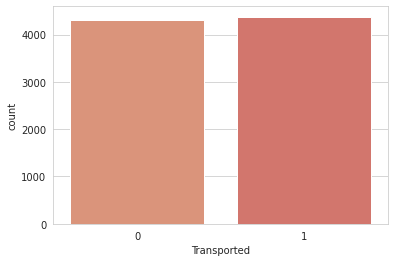

In [4]:
enc =LabelEncoder()
train['Transported'] = enc.fit_transform(train['Transported'])
sns.countplot(data=train,x=train.Transported)

**There is almost equal number of positive(1:transported) and negative(2:not Trasported) cases here so model would have equal instaces of positive and negative to learn from.**

In [5]:
#shape of train and test data
print('shape of train data:', train.shape)
print('shape of test data:', test.shape)

shape of train data: (8693, 14)
shape of test data: (4277, 13)


In [6]:
display(train.info())
print('='* 100)
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   int64  
dtypes: float64(6), int64(1), object(7)
memory usage: 950.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


None

In [7]:
num_col = [a for a in train.columns if train[a].dtype in ['float64']]
cat_col = [a for a in train.columns if train[a].dtype in ['object']]
print('\nNumerical_features',num_col)
print('\nCategorical_features',cat_col)


Numerical_features ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

Categorical_features ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']


In [8]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1


In [9]:
#target 
y = train['Transported']

In [10]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1


In [11]:
# % of null value per column in train and test data
display(round(train.isnull().sum().sort_values(ascending=False)/train.shape[0]*100,2))
print('='* 100)
display(round(test.isnull().sum().sort_values(ascending=False)/test.shape[0]*100,2))

CryoSleep       2.50
ShoppingMall    2.39
VIP             2.34
HomePlanet      2.31
Name            2.30
Cabin           2.29
VRDeck          2.16
FoodCourt       2.11
Spa             2.11
Destination     2.09
RoomService     2.08
Age             2.06
PassengerId     0.00
Transported     0.00
dtype: float64

FoodCourt       2.48
Spa             2.36
Cabin           2.34
ShoppingMall    2.29
Name            2.20
CryoSleep       2.17
VIP             2.17
Destination     2.15
Age             2.13
HomePlanet      2.03
RoomService     1.92
VRDeck          1.87
PassengerId     0.00
dtype: float64

# **Preprocessing**

In [12]:
def fill_values(df):
    df['ShoppingMall'] = SimpleImputer(strategy='constant',fill_value=0).fit_transform(df[['ShoppingMall']])
    df['RoomService'] = SimpleImputer(strategy='constant',fill_value=0).fit_transform(df[['RoomService']])
    df['FoodCourt'] = SimpleImputer(strategy='constant',fill_value=0).fit_transform(df[['FoodCourt']])
    df['Spa'] = SimpleImputer(strategy='constant',fill_value=0).fit_transform(df[['Spa']])
    df['VRDeck'] = SimpleImputer(strategy='constant',fill_value=0).fit_transform(df[['VRDeck']])
    df['Age'] = SimpleImputer(missing_values=np.nan,strategy='mean').fit_transform(df[['Age']])
    df['HomePlanet'] = SimpleImputer(strategy='most_frequent').fit_transform(df[['HomePlanet']])
    df['CryoSleep'] = SimpleImputer(strategy='most_frequent').fit_transform(df[['CryoSleep']])
    df['Cabin'] = SimpleImputer(strategy='most_frequent').fit_transform(df[['Cabin']])
    df['Destination'] = SimpleImputer(strategy='most_frequent').fit_transform(df[['Destination']])
    df['VIP'] = SimpleImputer(strategy='most_frequent').fit_transform(df[['VIP']])

fill_values(train)
fill_values(test)

In [13]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   object 
 3   Cabin         8693 non-null   object 
 4   Destination   8693 non-null   object 
 5   Age           8693 non-null   float64
 6   VIP           8693 non-null   object 
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   int64  
dtypes: float64(6), int64(1), object(7)
memory usage: 950.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null C

# **Feature Engg.**

In [14]:
train[['Group_No','No_in_group']] = train['PassengerId'].str.split("_",expand=True)

test[['Group_No','No_in_group']] = test['PassengerId'].str.split("_",expand=True)

In [15]:
#making a new feature with the sum of ShoppingMall, Spa, VRDeck, FoodCourt, RoomService
train['total_exp'] = train['ShoppingMall']+train['Spa']+train['VRDeck']+train['FoodCourt']+train['RoomService']

test['total_exp'] = test['ShoppingMall']+test['Spa']+test['VRDeck']+test['FoodCourt']+test['RoomService']

In [16]:
train['B_needs'] = train['RoomService']+train['FoodCourt']
train['L_needs'] = train['ShoppingMall']+train['Spa']+train['VRDeck']

test['B_needs'] = test['RoomService']+test['FoodCourt']
test['L_needs'] = test['ShoppingMall']+test['Spa']+test['VRDeck']


In [17]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group_No,No_in_group,total_exp,B_needs,L_needs
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0001,01,0.0,0.0,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,0002,01,736.0,118.0,618.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,0003,01,10383.0,3619.0,6764.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,0003,02,5176.0,1283.0,3893.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,0004,01,1091.0,373.0,718.0


<AxesSubplot:xlabel='Transported', ylabel='B_needs'>

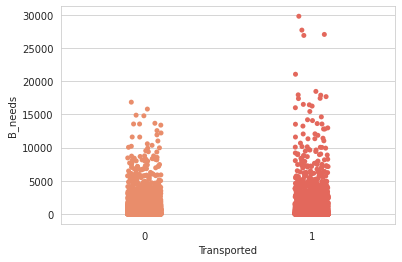

In [18]:
sns.stripplot(data=train,x='Transported',y='B_needs')

<AxesSubplot:xlabel='Transported', ylabel='L_needs'>

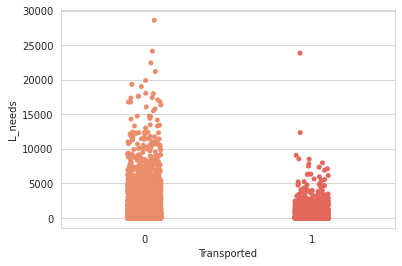

In [19]:
sns.stripplot(data=train,x='Transported',y='L_needs')

In [20]:
train[['Cabin_deck','Cabin_num','Cabin_side']] = train['Cabin'].str.split("/",expand=True)

test[['Cabin_deck','Cabin_num','Cabin_side']] = test['Cabin'].str.split("/",expand=True)

In [21]:
train.drop(columns=['PassengerId','Name','Cabin'],axis=1,inplace=True)

test.drop(columns=['PassengerId','Name','Cabin'],axis=1,inplace=True)

In [22]:
cat_col = [a for a in train.columns if train[a].dtype in ['object']]
num_col = [a for a in train.columns if train[a].dtype in ['float64']]
print("Categorical features: ",cat_col)
print('Numerical features: ', num_col)

Categorical features:  ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Group_No', 'No_in_group', 'Cabin_deck', 'Cabin_num', 'Cabin_side']
Numerical features:  ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'total_exp', 'B_needs', 'L_needs']


<AxesSubplot:xlabel='L_needs', ylabel='Density'>

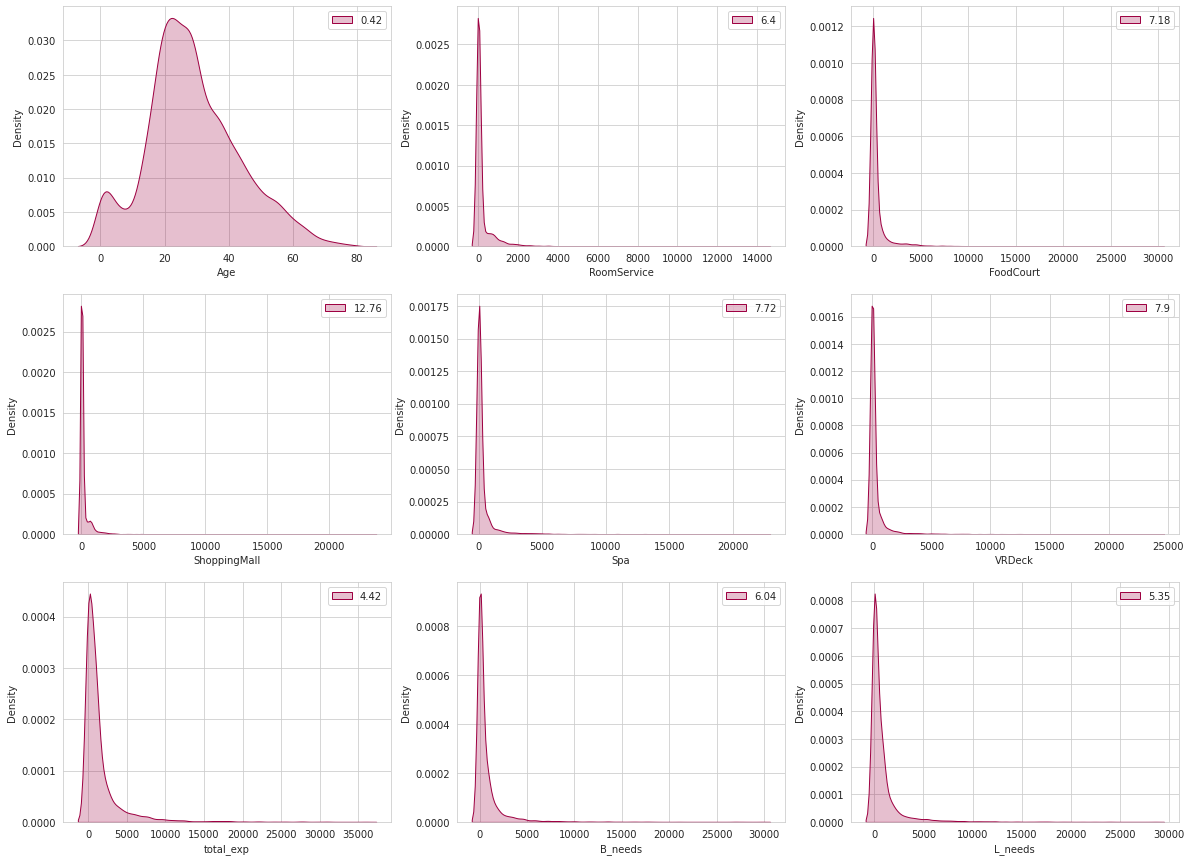

In [23]:
# #Visualizing the numerical features
fig,ax = plt.subplots(3,3,figsize=(20,15))

sns.kdeplot(ax=ax[0,0],x='Age',data=train, fill=True,hue=round(train['Age'].skew(),2),palette="Spectral")
sns.kdeplot(ax=ax[0,1],x='RoomService',data=train, fill=True, hue=round(train['RoomService'].skew(),2),palette='Spectral')
sns.kdeplot(ax=ax[0,2],x='FoodCourt',data=train, fill=True, hue=round(train['FoodCourt'].skew(),2),palette="Spectral")
sns.kdeplot(ax=ax[1,0],x='ShoppingMall',data=train, fill=True, hue=round(train['ShoppingMall'].skew(),2),palette="Spectral")
sns.kdeplot(ax=ax[1,1],x='Spa',data=train, fill=True, hue=round(train['Spa'].skew(),2),palette="Spectral")
sns.kdeplot(ax=ax[1,2],x='VRDeck',data=train, fill=True, hue=round(train['VRDeck'].skew(),2),palette="Spectral")
sns.kdeplot(ax=ax[2,0],x='total_exp',data=train, fill=True, hue=round(train['total_exp'].skew(),2),palette="Spectral")
sns.kdeplot(ax=ax[2,1],x='B_needs',data=train, fill=True, hue=round(train['B_needs'].skew(),2),palette="Spectral")
sns.kdeplot(ax=ax[2,2],x='L_needs',data=train, fill=True, hue=round(train['L_needs'].skew(),2),palette="Spectral")

> All Numerical features are tail-heavy, they are left-skewed

# **Preprocessing**

In [24]:
#log transformation
# train[num_col] = train[num_col].applymap(lambda x: np.log(x) if x>0 else 0)

In [25]:
#box-cox trasformation
train[num_col] =power_transform(train[num_col],method='yeo-johnson',standardize=True)

test[num_col] =power_transform(test[num_col],method='yeo-johnson',standardize=True)


> yeo-johnson worked better than log transformation in making the numerical distribution more guassian-like

<AxesSubplot:xlabel='L_needs', ylabel='Density'>

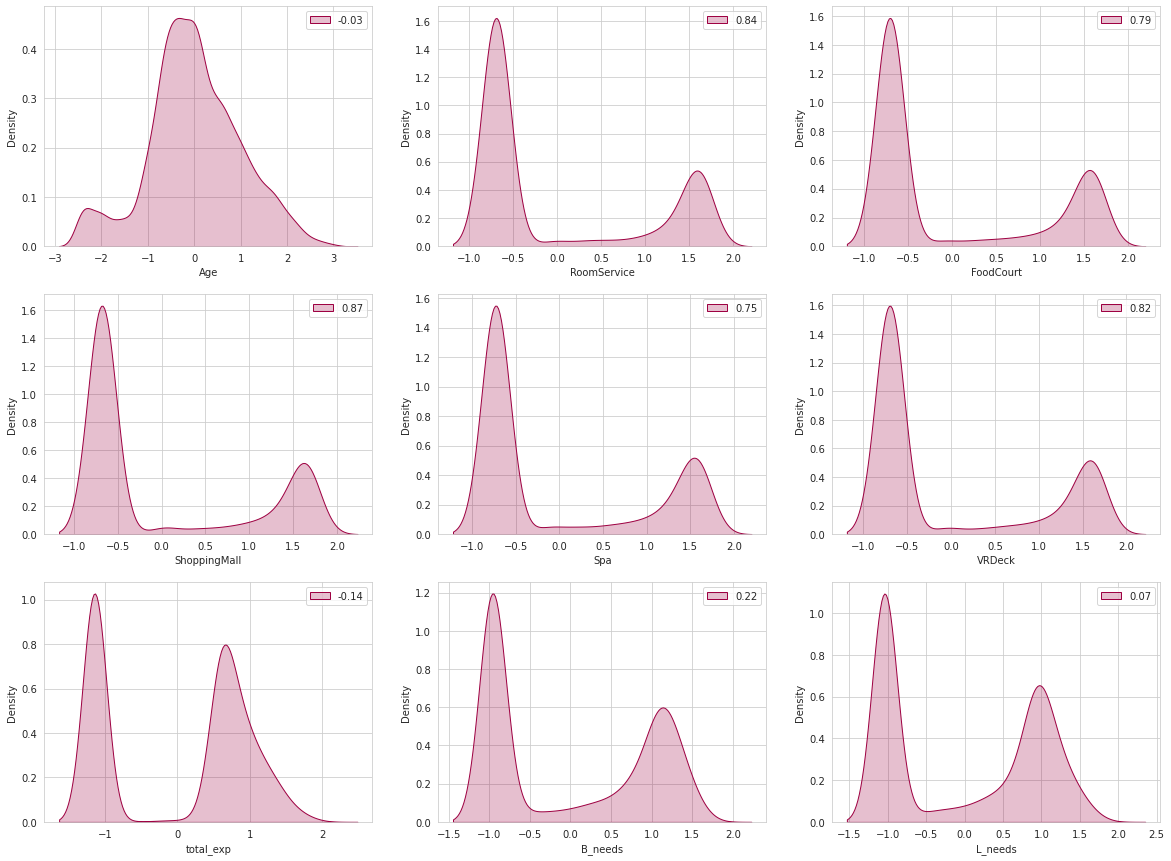

In [26]:
fig,ax = plt.subplots(3,3,figsize=(20,15))

sns.kdeplot(ax=ax[0,0],x='Age',data=train, fill=True,hue=round(train['Age'].skew(),2),palette="Spectral")
sns.kdeplot(ax=ax[0,1],x='RoomService',data=train, fill=True, hue=round(train['RoomService'].skew(),2),palette='Spectral')
sns.kdeplot(ax=ax[0,2],x='FoodCourt',data=train, fill=True, hue=round(train['FoodCourt'].skew(),2),palette="Spectral")
sns.kdeplot(ax=ax[1,0],x='ShoppingMall',data=train, fill=True, hue=round(train['ShoppingMall'].skew(),2),palette="Spectral")
sns.kdeplot(ax=ax[1,1],x='Spa',data=train, fill=True, hue=round(train['Spa'].skew(),2),palette="Spectral")
sns.kdeplot(ax=ax[1,2],x='VRDeck',data=train, fill=True, hue=round(train['VRDeck'].skew(),2),palette="Spectral")
sns.kdeplot(ax=ax[2,0],x='total_exp',data=train, fill=True, hue=round(train['total_exp'].skew(),2),palette="Spectral")
sns.kdeplot(ax=ax[2,1],x='B_needs',data=train, fill=True, hue=round(train['B_needs'].skew(),2),palette="Spectral")
sns.kdeplot(ax=ax[2,2],x='L_needs',data=train, fill=True, hue=round(train['L_needs'].skew(),2),palette="Spectral")

In [27]:
#encoding the categorical features
train[cat_col] = OrdinalEncoder().fit_transform(train[cat_col])

test[cat_col] = OrdinalEncoder().fit_transform(test[cat_col])

**We will onehot encode the categorical columns which have unique values of less than 5.And these are HomePlanet,CryoSleep,Destination,VIP,Cabin_side.**

In [28]:
# ohe = OneHotEncoder()

# ohe_col = ['HomePlanet','CryoSleep','Destination','VIP','Cabin_side']
# codes = ohe.fit_transform(train[ohe_col]).toarray()
# feature_names= ohe.get_feature_names(ohe_col)

# ohe_cat_train = pd.DataFrame(data=codes,columns=feature_names)
# train = train.drop(columns=ohe_col,axis=1)

# ohe_train = pd.concat([train, ohe_cat_train],axis=1)





In [29]:
# ohe_train['Cabin_deck'] = enc.fit_transform(ohe_train['Cabin_deck'])
# ohe_train['Group_No']= ohe_train['Group_No'].astype('int64')
# ohe_train['No_in_group']= ohe_train['No_in_group'].astype('int64')
# ohe_train['Cabin_num']= ohe_train['Cabin_num'].astype('int64')


In [30]:
# for i in ['Cabin_deck','Group_No','No_in_group','Cabin_num']:
#     ohe_train[[i]] =power_transform(ohe_train[[i]],method='yeo-johnson',standardize=True)
    

In [31]:
# ohe_train.head()

In [32]:
# for ordinal encoding

features = num_col + cat_col
X = train[features]
y = train['Transported']


In [33]:
# for OnehotEncoding
# features = list(train.columns)+ list(feature_names)
# X= ohe_train[features]
# y= ohe_train['Transported']



# **Training a model**

In [34]:
#finding optimal hyperparameters(GridSearchCV)

# parameters = {'penalty':['l2'], 
#               'C': [0, 0.1,0.5,1,5,10], 
#               'solver':['sag','saga','lbfgs'], 
#               'max_iter':[100,1000,10000,100000]
#               }

# model = LogisticRegression()
# Search = GridSearchCV(model, parameters, scoring= 'accuracy', n_jobs=1, 
#                      cv=5,verbose=1,).fit(X,y)

# optimal_parameters = Search.best_params_
# print("Optimal Parameters:",optimal_parameters)

In [35]:
#baysian optimization(finding parameters values that gives optimal performance to the model)

# n_iter = 100

# parameters = {'penalty':('l2'), 
#               'C': (0,10), 
#               'solver':('sag','saga'), 
#               'max_iter':(100,1000,10000,100000)
#               }

# model = LogisticRegression(random_state=42)
# Search = BayesSearchCV(model, parameters,n_iter=n_iter, scoring= 'accuracy', n_jobs=-1, 
#                      cv=5,verbose=0).fit(X,y)

# cv_results = pd.DataFrame(data= Search.cv_results_,columns= list(parameters.keys()))
# optimal_parameters = Search.best_params_
# print("Optimal Parameters:",optimal_parameters)

># **Logistic Baseline**

In [36]:
# cross-validation and logistic Regression

# cv=10
# metric = []

# kfold = KFold(n_splits=cv,random_state=52, shuffle=True)
# for idx,(train_idx, val_idx) in enumerate(kfold.split(ohe_train)):
#     xtrain, xvalid = X.loc[train_idx], X.loc[val_idx]
#     ytrain, yvalid = y.loc[train_idx], y.loc[val_idx]
    
#     #initializing a model
#     global log_model
#     log_model = LogisticRegression(penalty='l2',C=10,max_iter=1000,solver='liblinear')
#     log_model.fit(xtrain,ytrain)
#     pred_train= log_model.predict(xtrain)
#     preds = log_model.predict(xvalid)
#     #evaluation metric
#     accuracy_train = accuracy_score(ytrain,pred_train)
#     accuracy = accuracy_score(yvalid,preds)
#     metric.append(accuracy)
#     accu_tr_list.append(accuracy_train)
#     accu_te_list.append(accuracy)
#     print(f"accuracy in fold:{idx} is: {accuracy} and in valid_set is : {accuracy_train}")
# print(f"mean accuracy in {cv}folds is: {np.mean(metric)}")   
    

# 2.LinearSVC

In [37]:
# cv=10
# metric = []

# kfold = KFold(n_splits=cv,random_state=52, shuffle=True)
# for idx,(train_idx, val_idx) in enumerate(kfold.split(train)):
#     xtrain, xvalid = X.loc[train_idx], X.loc[val_idx]
#     ytrain, yvalid = y.loc[train_idx], y.loc[val_idx]
    
#     #initializing a model
#     global svc_model
#     svc_model = LinearSVC(C=5,dual=False)
#     svc_model.fit(xtrain,ytrain)
#     pred_train= svc_model.predict(xtrain)
#     preds = svc_model.predict(xvalid)
#     #evaluation metric
#     accuracy_train = accuracy_score(ytrain,pred_train)
#     accuracy = accuracy_score(yvalid,preds)
#     metric.append(accuracy)
#     print(f"accuracy in fold:{idx} is: {accuracy} and in train_set is : {accuracy_train}")
    
# print(f"mean accuracy in {cv}folds is: {np.mean(metric)}") 

In [38]:
#cross validation and DecisionTreeClassifier

# cv=10
# metric = []

# kfold = KFold(n_splits=cv,random_state=52, shuffle=True)
# for idx,(train_idx, val_idx) in enumerate(kfold.split(train)):
#     xtrain, xvalid = X.loc[train_idx], X.loc[val_idx]
#     ytrain, yvalid = y.loc[train_idx], y.loc[val_idx]
    
#     #initializing a model
#     global tree_model
#     tree_model = DecisionTreeClassifier(max_depth=50,
#                                         min_samples_split=2,
#                                         min_samples_leaf=2,
#                                         min_weight_fraction_leaf=0.0,
#                                         random_state=42,
#                                         max_leaf_nodes=8,
#                                         class_weight=None
#                                          )
#     tree_model.fit(xtrain,ytrain)
#     pred_train= tree_model.predict(xtrain)
#     preds = tree_model.predict(xvalid)
#     #evaluation metric
#     accuracy_train = accuracy_score(ytrain,pred_train)
#     accuracy = accuracy_score(yvalid,preds)
#     metric.append(accuracy)
#     print(f"accuracy in fold:{idx} is: {accuracy} and in train_set is : {accuracy_train}")
    
# print(f"mean accuracy in {cv}folds is: {np.mean(metric)}") 

# **Ensemble**

# 1.Bagging Classifier

In [39]:
# max_depth=50,
#                                    min_samples_split=2,
#                                    min_samples_leaf=2,
#                                    min_weight_fraction_leaf=0.0,
#                                    random_state=42,
#                                    max_leaf_nodes=8,
# #                                    class_weight=None

In [40]:
#cross validation and Ensemble of decision Trees with BaggingClassier(bagging classifier just work as providing 
# different random sample to different trees and then aggregating the predictions of all classifiers(most-frequent decisions), 
# we can use any model for bagging like SVC or logistic regression.



# cv=15
# metric = []
# accu_tr_list= list()
# accu_te_list = list()

# kfold = KFold(n_splits=cv,random_state=52,shuffle=True)
# for idx,(train_idx, val_idx) in enumerate(kfold.split(train)):
#     xtrain, xvalid = X.loc[train_idx], X.loc[val_idx]
#     ytrain, yvalid = y.loc[train_idx], y.loc[val_idx]
    
#     #initializing a model
#     global model
#     model = DecisionTreeClassifier(max_depth=50,
#                                    min_samples_split=2,
#                                    min_samples_leaf=2,
#                                    min_weight_fraction_leaf=0.0,
#                                    random_state=42,
#                                    max_leaf_nodes=8,
#                                    class_weight=None)
#     bag_clf = BaggingClassifier(base_estimator=model, n_estimators=500, 
#                                 bootstrap=True,max_samples=1000,n_jobs=-1)
    
#     bag_clf.fit(xtrain,ytrain)
#     pred_train= bag_clf.predict(xtrain)
#     preds = bag_clf.predict(xvalid)
#     #evaluation metric
#     accuracy_train = accuracy_score(ytrain,pred_train)
#     accuracy = accuracy_score(yvalid,preds)
#     metric.append(accuracy)
#     accu_tr_list.append(accuracy_train)
#     accu_te_list.append(accuracy)
#     print(f"accuracy in fold:{idx} is: {accuracy} and in train_set is : {accuracy_train}")
    
# print(f"mean accuracy in {cv}folds is: {np.mean(metric)}") 

# #plotting the accuracy in each fold
# acc_df = pd.DataFrame({'fold':np.arange(cv),'ac_train':np.around(np.array(accu_tr_list),4),
#                        'ac_valid':np.around(np.array(accu_te_list),4)})

# fig = px.line(acc_df,x='fold',y=acc_df.columns[1:])
# fig.show()

Training for 10 folds is giving good accuracy when we increase fold by to 15, it gives little better perfomance but in 20 fold it accuracy goes down in final submission. So 15  is optimal fold here:)
As we see in plot that accuracy in training set(ac_train) is almost same but accuracy in validation set (ac_valid) is fluctuating a lot. First it have gone up because our model was just in initial training set

In [41]:
#finding optimal hyperparameters(RandomizedSearchCV)

# n_iter =100
# parameters = {'max_depth':randint(50,1000), 
#               'max_samples': loguniform(0.5,1.0), 
#               'n_estimators':randint(50,500), 
#               'max_leaf_nodes':randint(5,30)
#               }

# model = RandomForestClassifier(random_state=42)
# Search = RandomizedSearchCV(model, parameters,n_iter=n_iter, scoring= 'accuracy', n_jobs=-1, 
#                      cv=5,verbose=1).fit(X,y)

# optimal_parameters = Search.best_params_
# print("Optimal Parameters:",optimal_parameters)

In [42]:
#baysian optimization(it worked better than Randomized seach CV, see this discussion for more,
# https://www.kaggle.com/discussions/questions-and-answers/379525#2108445)

# n_iter = 100
# parameters = {'max_depth':(50,1000), 
#               'max_samples': (0.5,1.0,"log-uniform"), 
#               'n_estimators':(50,500), 
#               'max_leaf_nodes':(5,30)
#               }

# model = RandomForestClassifier(random_state=42)
# Search = BayesSearchCV(model, parameters,n_iter=n_iter, scoring= 'accuracy', n_jobs=-1, 
#                      cv=5,verbose=1).fit(X,y)

# optimal_parameters = Search.best_params_
# print("Optimal Parameters:",optimal_parameters)

In [43]:
# #optuna
# def objective(trial):
#     max_depth = trial.suggest_int('max_depth',50,100)
#     max_samples = trial.suggest_loguniform('max_samples',0.5,1.0 )
#     n_estimators = trial.suggest_int('n_estimators',50,500)
#     max_leaf = trial.suggest_int('max_leaf_nodes',5,30)
#     clf =RandomForestClassifier(max_depth=max_depth,random_state=42,max_samples=max_samples,
#                                       max_leaf_nodes=max_leaf,n_estimators=n_estimators,)
#     return cross_val_score(clf,X,y,cv=5,scoring='accuracy',n_jobs=-1)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective,n_trials=100)

# trial = study.best_trial
# print(f"Accuracy: {trial.value}")
# print(f"best_parameter_combinations: {trial.params}")

# 2.RandomForestClassifier

In [44]:
# cross validation and Randomforest ensemble(like a shortcut of using bagging classifier and Decision tree as a base estimator)

cv=10
metric = []
accu_tr_list= list()
accu_te_list = list()

kfold = KFold(n_splits=cv,random_state=52,shuffle=True)
for idx,(train_idx, val_idx) in enumerate(kfold.split(train)):
    xtrain, xvalid = X.loc[train_idx], X.loc[val_idx]
    ytrain, yvalid = y.loc[train_idx], y.loc[val_idx]
    
    #initializing a model
    global rand_clf
    rand_clf = RandomForestClassifier(max_depth=534,random_state=42,max_samples=0.5,
                                      max_leaf_nodes=29,n_estimators=218,bootstrap=True)
    rand_clf.fit(xtrain,ytrain)
    pred_train= rand_clf.predict(xtrain)
    preds = rand_clf.predict(xvalid)
    #evaluation metric
    accuracy_train = accuracy_score(ytrain,pred_train)
    accuracy = accuracy_score(yvalid,preds)
    metric.append(accuracy)
    accu_tr_list.append(accuracy_train)
    accu_te_list.append(accuracy)
    print(f"accuracy in fold:{idx} is: {accuracy} and in train_set is : {accuracy_train}")
    
print(f"mean accuracy in {cv}folds is: {np.mean(metric)}") 

# plotting the accuracy in each fold
acc_df = pd.DataFrame({'fold':np.arange(cv),'ac_train':np.around(np.array(accu_tr_list),4),
                       'ac_valid':np.around(np.array(accu_te_list),4)})

fig = px.line(acc_df,x='fold',y=acc_df.columns[1:])
fig.show()


accuracy in fold:0 is: 0.8229885057471265 and in train_set is : 0.8014828071072478
accuracy in fold:1 is: 0.8080459770114943 and in train_set is : 0.8028889172951553
accuracy in fold:2 is: 0.8022988505747126 and in train_set is : 0.8042950274830628
accuracy in fold:3 is: 0.7779056386651323 and in train_set is : 0.8047034764826176
accuracy in fold:4 is: 0.8043728423475259 and in train_set is : 0.8034253578732107
accuracy in fold:5 is: 0.7951668584579977 and in train_set is : 0.8058537832310838
accuracy in fold:6 is: 0.7686996547756041 and in train_set is : 0.8068762781186094
accuracy in fold:7 is: 0.7790563866513234 and in train_set is : 0.8063650306748467
accuracy in fold:8 is: 0.766398158803222 and in train_set is : 0.8071319018404908
accuracy in fold:9 is: 0.8009205983889528 and in train_set is : 0.8040644171779141
mean accuracy in 10folds is: 0.7925853471423092


Randomized search cv so far helped find best performance.
BaysianSearchCV have beaten the RandomizedSearchCV and it searched the hyperparameters performed best in final score(0.79752) in 10 folds

In [45]:
#baysian optimization
# n_iter = 100

# parameters = {'max_depth':(50,1000), 
#               'max_samples': (0.5,1.0,"log-uniform"), 
#               'n_estimators':(50,500), 
#               'max_leaf_nodes':(5,30)
#               }

# model = ExtraTreesClassifier(random_state=42,bootstrap=True)
# Search = BayesSearchCV(model, parameters,n_iter=n_iter, scoring= 'accuracy', n_jobs=-1, 
#                      cv=5,verbose=0).fit(X,y)

# cv_results = pd.DataFrame(data= Search.cv_results_,columns= list(parameters.keys()))
# optimal_parameters = Search.best_params_
# print("Optimal Parameters:",optimal_parameters)

# 3.ExtraTreeClassifier

In [46]:
# ExtraTreeClassifier(almost same like Randomforest,just more randomized than Randomforest model. In this algorithm, the threshold in feature 
# splitting is random than best, see in decision tree documentation a parameter named, 'splitter'. In RandomForest,this Decision tree 
# parameter is set to 'best' by default and in Extratree it is set to 'random')

# cv=10
# metric = []
# accu_tr_list= list()
# accu_te_list = list()

# kfold = KFold(n_splits=cv,random_state=42,shuffle=True)
# for idx,(train_idx, val_idx) in enumerate(kfold.split(train)):
#     xtrain, xvalid = X.loc[train_idx], X.loc[val_idx]
#     ytrain, yvalid = y.loc[train_idx], y.loc[val_idx]
    
#     #initializing a model
#     et_clf = ExtraTreesClassifier(max_depth=1000,random_state=42,bootstrap=True,
#                                       max_leaf_nodes=30,n_estimators=50,max_samples=.85)
#     et_clf.fit(xtrain,ytrain)
#     pred_train= et_clf.predict(xtrain)
#     preds = et_clf.predict(xvalid)
#     #evaluation metric
#     accuracy_train = accuracy_score(ytrain,pred_train)
#     accuracy = accuracy_score(yvalid,preds)
#     metric.append(accuracy)
#     accu_tr_list.append(accuracy_train)
#     accu_te_list.append(accuracy)
#     print(f"accuracy in fold:{idx} is: {accuracy} and in train_set is : {accuracy_train}")
    
# print(f"mean accuracy in {cv}folds is: {np.mean(metric)}") 

# # plotting the accuracy in each fold
# acc_df = pd.DataFrame({'fold':np.arange(cv),'ac_train':np.around(np.array(accu_tr_list),4),
#                        'ac_valid':np.around(np.array(accu_te_list),4)})

# fig = px.line(acc_df,x='fold',y=acc_df.columns[1:])
# fig.show()


ExtraTreeClassifier haven't performed better than RandomForest Classifier.

# 4. AdaBoostClassifier

In [47]:
#AdaBoost with DecisionTreeClassifier as base estimator(here we are using our optimized DecisionTree Classifier,
# used previously in notebook)



# cv=10
# metric = []
# accu_tr_list= list()
# accu_te_list = list()

# kfold = KFold(n_splits=cv,random_state=42,shuffle=True)
# for idx,(train_idx, val_idx) in enumerate(kfold.split(train)):
#     xtrain, xvalid = X.loc[train_idx], X.loc[val_idx]
#     ytrain, yvalid = y.loc[train_idx], y.loc[val_idx]
    
    #initializing a model
#     tree_model = DecisionTreeClassifier(max_depth=50,
#                                         min_samples_split=2,
#                                         min_samples_leaf=2,
#                                         min_weight_fraction_leaf=0.0,
#                                         random_state=42,
#                                         max_leaf_nodes=8,
#                                         class_weight=None
#                                          ) 
#     ada_clf = AdaBoostClassifier(tree_model,algorithm='SAMME.R',
#                                  n_estimators=50,
#                                  learning_rate=0.02)
#     ada_clf.fit(xtrain,ytrain)
#     pred_train= ada_clf.predict(xtrain)
#     preds = ada_clf.predict(xvalid)
#     #evaluation metric
#     accuracy_train = accuracy_score(ytrain,pred_train)
#     accuracy = accuracy_score(yvalid,preds)
#     metric.append(accuracy)
#     accu_tr_list.append(accuracy_train)
#     accu_te_list.append(accuracy)
#     print(f"accuracy in fold:{idx} is: {accuracy} and in train_set is : {accuracy_train}")
    
# print(f"mean accuracy in {cv}folds is: {np.mean(metric)}") 

# # plotting the accuracy in each fold
# acc_df = pd.DataFrame({'fold':np.arange(cv),'ac_train':np.around(np.array(accu_tr_list),4),
#                        'ac_valid':np.around(np.array(accu_te_list),4)})

# fig = px.line(acc_df,x='fold',y=acc_df.columns[1:])
# fig.show()



**Here Adaboost with base_estimator as DecisionTreeClassifier is performing better in accuracy but at submission it is performing worse than 
RandomForestClassifier, so for now RandomForest ensemble is still best performer.**

# 5. GradientBoosting

sklearn provides gradient boosting algorithm, for large datasets(>10000) [HistGradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier) is fast but our dataset is not large so [GradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier)  will be enough.

In [48]:
#baysian optimization(finding parameters values that gives optimal performance to the model)

# n_iter = 100

# parameters = {'max_depth':(50,1000), 
#               'learning_rate': (.01, 0.1,'log-uniform'), 
#               'n_estimators':(50,500), 
#               'max_leaf_nodes':(2,20),
#               'min_samples_split':(2,4)
#               }

# model = GradientBoostingClassifier(random_state=42)
# Search = BayesSearchCV(model, parameters,n_iter=n_iter, scoring= 'accuracy', n_jobs=-1, 
#                      cv=5,verbose=0).fit(X,y)

# cv_results = pd.DataFrame(data= Search.cv_results_,columns= list(parameters.keys()))
# optimal_parameters = Search.best_params_
# print("Optimal Parameters:",optimal_parameters)

In [49]:
#gradient boosting

# cv=10
# metric = []
# accu_tr_list= list()
# accu_te_list = list()

# kfold = KFold(n_splits=cv,random_state=42,shuffle=True)
# for idx,(train_idx, val_idx) in enumerate(kfold.split(train)):
#     xtrain, xvalid = X.loc[train_idx], X.loc[val_idx]
#     ytrain, yvalid = y.loc[train_idx], y.loc[val_idx]
    
#     #initializing a model
#     grad_clf = GradientBoostingClassifier(max_depth=50,
#                                         min_samples_split=4,
#                                         min_samples_leaf=2,
#                                         min_weight_fraction_leaf=0.0,
#                                         random_state=42,
#                                         max_leaf_nodes=9,
#                                         n_estimators=50,
#                                         learning_rate=0.012870969735418545  
#                                         )
#     grad_clf.fit(xtrain,ytrain)
#     pred_train= grad_clf.predict(xtrain)
#     preds = grad_clf.predict(xvalid)
#     #evaluation metric
#     accuracy_train = accuracy_score(ytrain,pred_train)
#     accuracy = accuracy_score(yvalid,preds)
#     metric.append(accuracy)
#     accu_tr_list.append(accuracy_train)
#     accu_te_list.append(accuracy)
#     print(f"accuracy in fold:{idx} is: {accuracy} and in train_set is : {accuracy_train}")
    
# print(f"mean accuracy in {cv}folds is: {np.mean(metric)}") 

# # plotting the accuracy in each fold
# acc_df = pd.DataFrame({'fold':np.arange(cv),'ac_train':np.around(np.array(accu_tr_list),4),
#                        'ac_valid':np.around(np.array(accu_te_list),4)})

# fig = px.line(acc_df,x='fold',y=acc_df.columns[1:])
# fig.show()


In [50]:
# cv=10
# metric = []
# accu_tr_list= list()
# accu_te_list = list()

# kfold = KFold(n_splits=cv,random_state=42,shuffle=True)
# for idx,(train_idx, val_idx) in enumerate(kfold.split(train)):
#     xtrain, xvalid = X.loc[train_idx], X.loc[val_idx]
#     ytrain, yvalid = y.loc[train_idx], y.loc[val_idx]
    
#     #initializing a model
#     grad_clf = HistGradientBoostingClassifier(max_depth=5,
#                                         min_samples_leaf=2,
#                                         random_state=42,
#                                         max_leaf_nodes=9,
#                                         learning_rate=0.012 
#                                         )
#     grad_clf.fit(xtrain,ytrain)
#     pred_train= grad_clf.predict(xtrain)
#     preds = grad_clf.predict(xvalid)
#     #evaluation metric
#     accuracy_train = accuracy_score(ytrain,pred_train)
#     accuracy = accuracy_score(yvalid,preds)
#     metric.append(accuracy)
#     accu_tr_list.append(accuracy_train)
#     accu_te_list.append(accuracy)
#     print(f"accuracy in fold:{idx} is: {accuracy} and in train_set is : {accuracy_train}")
    
# print(f"mean accuracy in {cv}folds is: {np.mean(metric)}") 

# # plotting the accuracy in each fold
# acc_df = pd.DataFrame({'fold':np.arange(cv),'ac_train':np.around(np.array(accu_tr_list),4),
#                        'ac_valid':np.around(np.array(accu_te_list),4)})

# fig = px.line(acc_df,x='fold',y=acc_df.columns[1:])
# fig.show()


# 6.Stacking_1(LogisticRegresion, LinearSVC,DecisionTree)


So far we have tried LogisticRegression, SVC, DecisionTreeClassifier, BaggingClassifier,RandomForestClassifier,ExtraTreeClassifier and 
Gradient boosting and RandomForest was among them best performer was RandomForestClassifier after optimization with the help of BeyesianSearchCV. We have left one ensemble mathod which will combine some models and make prediction on prediction of those predictors,
It is called Stacking. I will combine LogisticRegression, LinearSVC and DecisionTreeClassifier as learners(which themselves are optimized individually) are  and RandomForest as Meta Learner in the process of stacking. If you want to check what is stacking, this [video](https://youtu.be/xtTyEoJ31Vg) is good, it helped me and might help you. 

In [51]:
# cv=10
# clf1 = LogisticRegression(penalty='l2',C=10,max_iter=1000,solver='liblinear')
# clf2 = LinearSVC(C=5,dual=False)
# clf3_3 = DecisionTreeClassifier(max_depth=50,
#                               min_samples_split=2,
#                               min_samples_leaf=2,
#                               min_weight_fraction_leaf=0.0,
#                               random_state=42,
#                               max_leaf_nodes=8,
#                                         )
                                         
# m_clf = RandomForestClassifier(max_depth=534,random_state=42,max_samples=0.5,
#                                       max_leaf_nodes=29,n_estimators=218,bootstrap=True)
# sclf_first = StackingClassifier(classifiers=[clf1,clf2,clf3_3],
#                              meta_classifier=m_clf)
# ac = list()
# for clf,label in zip([clf1,clf2,clf3_3,sclf_first],
#                      ['Logistic Regression','LinearSVC,','DecisionTreeClassifier','StackingClassifier']):
    
#     kfold = KFold(n_splits=cv,random_state=42,shuffle=True)
#     for idx,(train_idx, val_idx) in enumerate(kfold.split(train)):
#         xtrain, xvalid = X.loc[train_idx], X.loc[val_idx]
#         ytrain, yvalid = y.loc[train_idx], y.loc[val_idx]

#         #initializing a model
#         clf.fit(xtrain,ytrain)
#         preds = clf.predict(xvalid)
#         #evaluation metric
#         accuracy = accuracy_score(yvalid,preds)
#         ac.append(accuracy)
#     print(f"Accuracy in {label}: {mean(ac)}")
#     ac.clear()    





As we see Stacking mathod perform better than their predecessors.But not as better as RandomForestClassifier

# 7.Stacking_2(AdaBoost, RandomForest,BaggingClassifier)

In [52]:
# cv=10
# clf1 = AdaBoostClassifier(clf3_3,algorithm='SAMME.R',
#                                  n_estimators=50,
#                                  learning_rate=0.02)
# clf2 = RandomForestClassifier(max_depth=534,random_state=42,max_samples=0.5,
#                                       max_leaf_nodes=29,n_estimators=218,bootstrap=True)
# clf3 = BaggingClassifier(base_estimator=clf3_3, n_estimators=500, 
#                                 bootstrap=True,max_samples=1000,n_jobs=-1)
# m_clf = GradientBoostingClassifier(max_depth=50,
#                                         min_samples_split=4,
#                                         min_samples_leaf=2,
#                                         min_weight_fraction_leaf=0.0,
#                                         random_state=42,
#                                         max_leaf_nodes=9,
#                                         n_estimators=50,
#                                         learning_rate=0.012870969735418545  
#                                         ) 

# sclf_second = StackingClassifier(classifiers=[clf1,clf2,clf3],
#                              meta_classifier=m_clf)
# ac = list()
# for clf,label in zip([clf1,clf2,clf3,sclf_second],
#                      ['AdaBoostClassifier','RandomForestClassifier,','BaggingClassifier','StackingClassifier']):
    
#     kfold = KFold(n_splits=cv,random_state=42,shuffle=True)
#     for idx,(train_idx, val_idx) in enumerate(kfold.split(train)):
#         xtrain, xvalid = X.loc[train_idx], X.loc[val_idx]
#         ytrain, yvalid = y.loc[train_idx], y.loc[val_idx]

#         #initializing a model
#         clf.fit(xtrain,ytrain)
#         preds = clf.predict(xvalid)
#         #evaluation metric
#         accuracy = accuracy_score(yvalid,preds)
#         ac.append(accuracy)
#     print(f"Accuracy in {label}: {mean(ac)}")
#     ac.clear()

Seems like no one is going to perform better than RandomForest:))

# 8. Xgboost+Optuna

In [53]:
#optuna
# def objective(trial):     
#     max_depth = trial.suggest_int('max_depth',50,200)
#     sub_samples = trial.suggest_float('sub_samples',0.5,1.0 )
#     gamma = trial.suggest_float('gamma',0.1,0.6 )
#     reg_alpha = trial.suggest_float('reg_alpha',0.1,0.6 )
#     reg_lambda = trial.suggest_float('reg_lambda',0.1,0.6 )
#     n_estimators = trial.suggest_int('n_estimators',50,500)

#     xgb_clf =XGBClassifier(max_depth=max_depth,random_state=42,sub_samples=sub_samples,
#                                       gamma=gamma,n_estimators=n_estimators,reg_alpha=reg_alpha,
#                                       reg_lambda=reg_lambda)
#     accruacy = cross_val_score(xgb_clf,X,y,cv=5,scoring='accuracy',n_jobs=-1)
#     return accuracy

    
# try:   
#     study = optuna.create_study(direction='maximize')
#     study.optimize(objective,n_trials=100)
#     trial = study.best_trial

#     print(f"Accuracy: {trial.value}")
#     print(f"best_parameter_combinations: {trial.params}")

#     print(f"best_parameter_combinations: {trial.params}")
# except:
#     raise Exception('this is wrong!!')


   

In [54]:
# {"n_estimators":392,
#           "subsample": 1.0,
#           'max_depth':188,
#           'learning_rate':0.02,
#            'gamma':0.15,
#            'reg_alpha':0.16,
#            'reg_lambda':0.31}

# 'learning_rate':0.02,
#      'lambda_l1': 1.945,
#      'num_leaves': 87,
#      'feature_fraction': 0.79,
#      'bagging_fraction': 0.93,
#      'bagging_freq': 4,
#      'min_data_in_leaf': 103,

In [55]:
#xgboost

cv=10
metric = []
accu_tr_list= list()
accu_te_list = list()
params = {"n_estimators":392,
          "subsample": 0.1,
          'max_depth':150,
          'learning_rate':0.02,
           'gamma':0.30,
           'reg_alpha':0.2,
           'reg_lambda':0.2}

kfold = KFold(n_splits=cv,random_state=42,shuffle=True)
for idx,(train_idx, val_idx) in enumerate(kfold.split(train)):
    xtrain, xvalid = X.loc[train_idx], X.loc[val_idx]
    ytrain, yvalid = y.loc[train_idx], y.loc[val_idx]
    
    #initializing a model
    xgb_clf = XGBClassifier(**params,)
    xgb_clf.fit(xtrain,ytrain,early_stopping_rounds=5, eval_set=[(xvalid,yvalid)],verbose=False)
    pred_train= xgb_clf.predict(xtrain)
    preds = xgb_clf.predict(xvalid)
    #evaluation metric
    accuracy_train = accuracy_score(ytrain,pred_train)
    accuracy = accuracy_score(yvalid,preds)
    metric.append(accuracy)
    accu_tr_list.append(accuracy_train)
    accu_te_list.append(accuracy)
    print(f"accuracy in fold:{idx} is: {accuracy} and in train_set is : {accuracy_train}")
    
print(f"mean accuracy in {cv}folds is: {np.mean(metric)}") 

# plotting the accuracy in each fold
acc_df = pd.DataFrame({'fold':np.arange(cv),'ac_train':np.around(np.array(accu_tr_list),4),
                       'ac_valid':np.around(np.array(accu_te_list),4)})

fig = px.line(acc_df,x='fold',y=acc_df.columns[1:])
fig.show()

accuracy in fold:0 is: 0.7908045977011494 and in train_set is : 0.8437939409433721
accuracy in fold:1 is: 0.8045977011494253 and in train_set is : 0.8450722229323789
accuracy in fold:2 is: 0.8080459770114943 and in train_set is : 0.8463505049213856
accuracy in fold:3 is: 0.7986191024165707 and in train_set is : 0.8417689161554193
accuracy in fold:4 is: 0.7963176064441887 and in train_set is : 0.8449642126789366
accuracy in fold:5 is: 0.8170310701956272 and in train_set is : 0.8408742331288344
accuracy in fold:6 is: 0.7974683544303798 and in train_set is : 0.8417689161554193
accuracy in fold:7 is: 0.8170310701956272 and in train_set is : 0.8459867075664622
accuracy in fold:8 is: 0.7917146144994246 and in train_set is : 0.843941717791411
accuracy in fold:9 is: 0.8020713463751439 and in train_set is : 0.843558282208589
mean accuracy in 10folds is: 0.8023701440419032


Text(0.5, 0, 'Feature Importance')

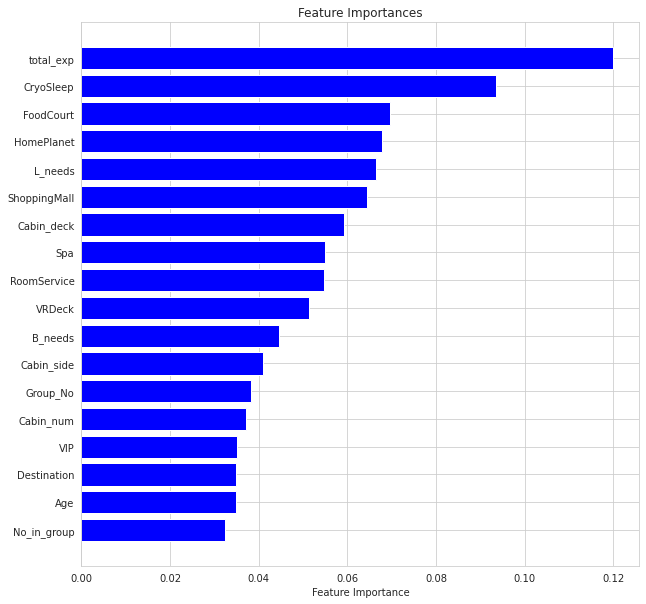

In [56]:
#code from this discussion: https://www.kaggle.com/code/umongsain/majority-voting-for-spaceship-score-0-8/comments

importances = xgb_clf.feature_importances_
importances
indices = np.argsort(importances)
plt.figure(figsize=(10, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Feature Importance')

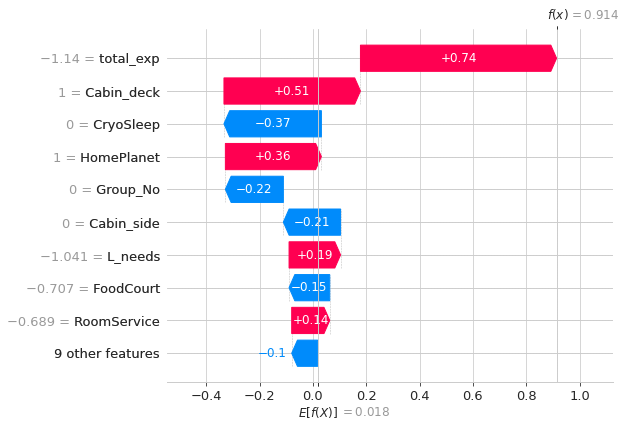

In [57]:
explainer = shap.Explainer(xgb_clf)
shap_values = explainer(X)

shap.plots.waterfall(shap_values[0])

In [58]:
X_test = test[features]


In [59]:
preds_test = xgb_clf.predict(X_test)
ids = test_c['PassengerId'].values


In [60]:
submission_file = pd.DataFrame(data={"PassengerId": ids, "Transported": preds_test})
submission_file['Transported'] = submission_file['Transported'].astype('bool')
submission_file.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [61]:
#final submission file
submission_file.to_csv("submission.csv",index=None)